# Binary Classification with a Bank Churn Dataset

Repository: https://github.com/qw1zzard/playground-series-s4e1

## Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostClassifier
from optuna import create_study
from optuna.samplers import TPESampler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

SEED = 31415

e:\GitHub\playground-series-s4e1\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data download and light analysis

In [2]:
train = pd.read_csv(
    '../input/playground-series-s4e1/train.csv', index_col='id')
test = pd.read_csv('../input/playground-series-s4e1/test.csv', index_col='id')
train.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,,,,,,,,,,,,,
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [3]:
len(train), len(train.CustomerId.unique())

(165034, 23221)

In [4]:
train.groupby(['CustomerId']).count().sort_values(['Surname'], ascending=False)

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CustomerId,,,,,,,,,,,,
15682355,121,121,121,121,121,121,121,121,121,121,121,121
15570194,99,99,99,99,99,99,99,99,99,99,99,99
15585835,98,98,98,98,98,98,98,98,98,98,98,98
15595588,91,91,91,91,91,91,91,91,91,91,91,91
15648067,90,90,90,90,90,90,90,90,90,90,90,90
...,...,...,...,...,...,...,...,...,...,...,...,...
15641625,1,1,1,1,1,1,1,1,1,1,1,1
15641624,1,1,1,1,1,1,1,1,1,1,1,1
15641621,1,1,1,1,1,1,1,1,1,1,1,1


In [5]:
train[train.CustomerId == 15682355]

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,,,,,,,,,,,,,
273,15682355,Hsueh,727,Germany,Male,35.0,9,140966.55,1,1.0,1.0,179227.21,0
2565,15682355,Tien,744,France,Male,37.0,6,0.00,2,1.0,1.0,137944.16,0
5063,15682355,Niu,790,Spain,Male,44.0,1,128100.75,1,1.0,0.0,164517.96,1
11942,15682355,Hsueh,616,France,Female,43.0,9,95167.82,2,0.0,1.0,132741.56,0
13009,15682355,Manna,652,Spain,Female,33.0,7,0.00,2,1.0,1.0,112333.22,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
159573,15682355,Onwuatuegwu,679,France,Female,39.0,6,0.00,2,1.0,0.0,123977.86,0
159690,15682355,Pinto,629,Germany,Female,34.0,2,140510.34,2,1.0,0.0,143681.75,0
159923,15682355,O'Donnell,710,France,Female,35.0,7,0.00,2,1.0,1.0,147055.87,0


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 165034 entries, 0 to 165033
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CustomerId       165034 non-null  int64  
 1   Surname          165034 non-null  object 
 2   CreditScore      165034 non-null  int64  
 3   Geography        165034 non-null  object 
 4   Gender           165034 non-null  object 
 5   Age              165034 non-null  float64
 6   Tenure           165034 non-null  int64  
 7   Balance          165034 non-null  float64
 8   NumOfProducts    165034 non-null  int64  
 9   HasCrCard        165034 non-null  float64
 10  IsActiveMember   165034 non-null  float64
 11  EstimatedSalary  165034 non-null  float64
 12  Exited           165034 non-null  int64  
dtypes: float64(5), int64(5), object(3)
memory usage: 17.6+ MB


In [7]:
train['isTrain'] = 1
test['isTrain'] = 0
data = pd.concat([train.drop('Exited', axis=1), test])
data.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,isTrain
id,,,,,,,,,,,,,
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,1
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,1
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,1
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,1
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,1


In [8]:
data.drop(['CustomerId', 'Surname'], axis=1, inplace=True)
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,isTrain
id,,,,,,,,,,,
0,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,1
1,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,1
2,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,1
3,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,1
4,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,1


## Split data into samples

In [9]:
train = pd.concat([data[data.isTrain == 1].drop(
    'isTrain', axis=1), train['Exited']], axis=1)
test = data[data.isTrain == 0].drop('isTrain', axis=1)
train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,,,,,,,,,,,
0,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [10]:
train_X = train.drop('Exited', axis=1)
train_y = pd.DataFrame(train.Exited)
train_X.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
id,,,,,,,,,,
0,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97
1,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50
2,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69
3,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88
4,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83


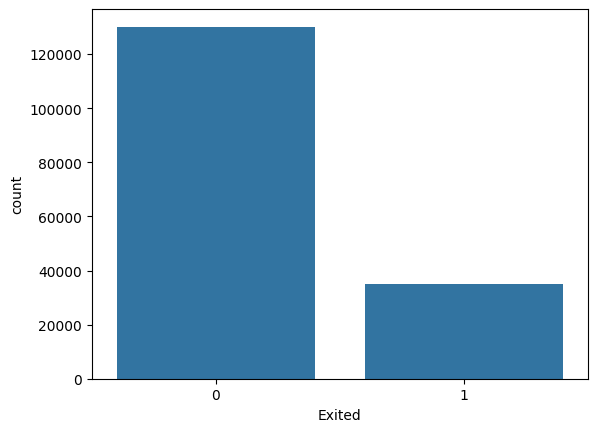

In [11]:
sns.countplot(x=train.Exited)
plt.show()

In [12]:
train_data, val_data, train_labels, val_labels = train_test_split(
    train_X, train_y, test_size=0.2, random_state=SEED)
val_labels.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33007 entries, 102857 to 134368
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Exited  33007 non-null  int64
dtypes: int64(1)
memory usage: 515.7 KB


## Prepare model

In [13]:
model = CatBoostClassifier(eval_metric='AUC',
                           cat_features=['Geography', 'Gender'],
                           random_state=SEED)

model.fit(X=train_data, y=train_labels, silent=True)

In [14]:
val_predicted = pd.DataFrame(model.predict(val_data, prediction_type='Probability')[:, 1],
                             columns=['Exited'], index=val_data.index)

val_predicted.head()

,Exited
id,
102857,0.734417
53498,0.033351
15240,0.218683
123713,0.040401
72187,0.061520


In [15]:
print('Base model ROC AUC score: ', roc_auc_score(val_labels, val_predicted))

Base model ROC AUC score:  0.8873464353152294


In [16]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'boosting_type': trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
    }

    model = CatBoostClassifier(**params,
                               eval_metric='AUC',
                               cat_features=['Geography', 'Gender'],
                               random_state=SEED)

    model.fit(X=train_data, y=train_labels, silent=True)
    val_predicted = pd.DataFrame(model.predict(val_data, prediction_type='Probability')[:, 1],
                                 columns=['Exited'], index=val_data.index)

    return roc_auc_score(val_labels, val_predicted)


sampler = TPESampler(seed=SEED)
study = create_study(direction='maximize', sampler=sampler)

study.optimize(objective, timeout=1800)

[I 2024-01-05 18:45:34,847] A new study created in memory with name: no-name-1c22b481-e313-4ea9-943b-f5a816f6e76d
[I 2024-01-05 18:47:26,898] Trial 0 finished with value: 0.8865844771730755 and parameters: {'learning_rate': 0.06812367453178793, 'depth': 8, 'l2_leaf_reg': 9.73633587443804, 'boosting_type': 'Plain'}. Best is trial 0 with value: 0.8865844771730755.
[I 2024-01-05 18:49:36,587] Trial 1 finished with value: 0.8882738392040894 and parameters: {'learning_rate': 0.08412336697039931, 'depth': 6, 'l2_leaf_reg': 6.588942216912418, 'boosting_type': 'Ordered'}. Best is trial 1 with value: 0.8882738392040894.
[I 2024-01-05 18:52:17,802] Trial 2 finished with value: 0.8876926901431809 and parameters: {'learning_rate': 0.08876972003269505, 'depth': 7, 'l2_leaf_reg': 1.9602999127065246, 'boosting_type': 'Ordered'}. Best is trial 1 with value: 0.8882738392040894.
[I 2024-01-05 18:54:50,690] Trial 3 finished with value: 0.8880737219234228 and parameters: {'learning_rate': 0.05510478047443

In [17]:
study.best_params

{'learning_rate': 0.04319760975354092,
 'depth': 5,
 'l2_leaf_reg': 3.0755391080096084,
 'boosting_type': 'Ordered'}

In [18]:
best_model = CatBoostClassifier(**study.best_params,
                                eval_metric='AUC',
                                cat_features=['Geography', 'Gender'],
                                random_state=SEED)

best_model.fit(X=train_data, y=train_labels, silent=True)

## Record final result

In [19]:
predict = np.array(best_model.predict(test, prediction_type='Probability')[:, 1])
predict

array([0.02455824, 0.82649917, 0.03068101, ..., 0.01777698, 0.15169469,
       0.16701869])

In [20]:
output = pd.DataFrame(columns=['id', 'Exited'])
output['id'] = test.index
output['Exited'] = predict
output.to_csv('submission.csv', index=False)
output.head()

,id,Exited
0,165034,0.024558
1,165035,0.826499
2,165036,0.030681
3,165037,0.231176
4,165038,0.373620


In [21]:
output.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110023 entries, 0 to 110022
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      110023 non-null  int64  
 1   Exited  110023 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 1.7 MB
